In [2]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import nltk
import spacy
import copy
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ignat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import danych

In [ ]:
df = pd.read_csv("../data/old_data/raw/clean_news.csv")
df.head()

,title,text,date,label
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,2016-01-17,0
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,2017-11-19,0
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,2017-09-04,0
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,2016-01-11,1
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,2016-03-31,1


Dane zawierają artykuły z tytułami, tekstami, datami i etykietami (0 lub 1). Etykieta 0 to artykuły prawdziwe, a 1 to fake newsy. 

# Rozkład klas

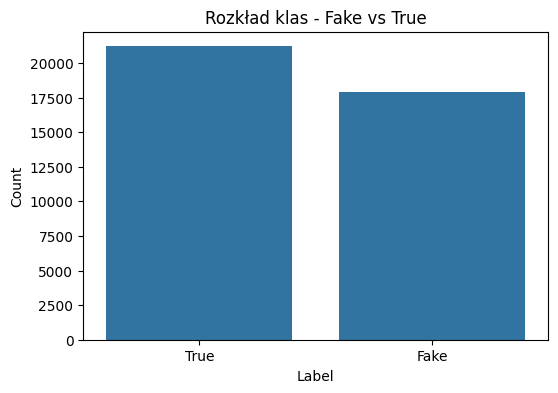

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(data=df,x = "label",)
plt.title("Rozkład klas - Fake vs True")
plt.xticks([0, 1], ['True', 'Fake'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

W zbiorze danych jest więcej artykułów prawdziwych niż fake newsów, ale nie ma dużej dysproporcji.


# Długość tytułów i tekstów

In [5]:
df['title_length'] = df['title'].apply(len)
df['text_length'] = df['text'].apply(len)

In [6]:
df['title_length'].describe()

count    39105.000000
mean        76.837412
std         22.282635
min          8.000000
25%         62.000000
50%         71.000000
75%         87.000000
max        286.000000
Name: title_length, dtype: float64

In [7]:
df[['title_length','label']].groupby(by='label').mean()

,title_length
label,
0,64.658631
1,91.252960


In [8]:
df['text_length'].describe()

count    39105.000000
mean      2428.043217
std       1943.270658
min          1.000000
25%       1267.000000
50%       2211.000000
75%       3080.000000
max      51794.000000
Name: text_length, dtype: float64

In [9]:
df[['text_length','label']].groupby(by='label').mean()

,text_length
label,
0,2378.697646
1,2486.451642


C:\Users\ignat\AppData\Local\Temp\ipykernel_10888\482162740.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x='label', y='title_length', palette='Set1')
C:\Users\ignat\AppData\Local\Temp\ipykernel_10888\482162740.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x='label',y='text_length', palette='Set2')


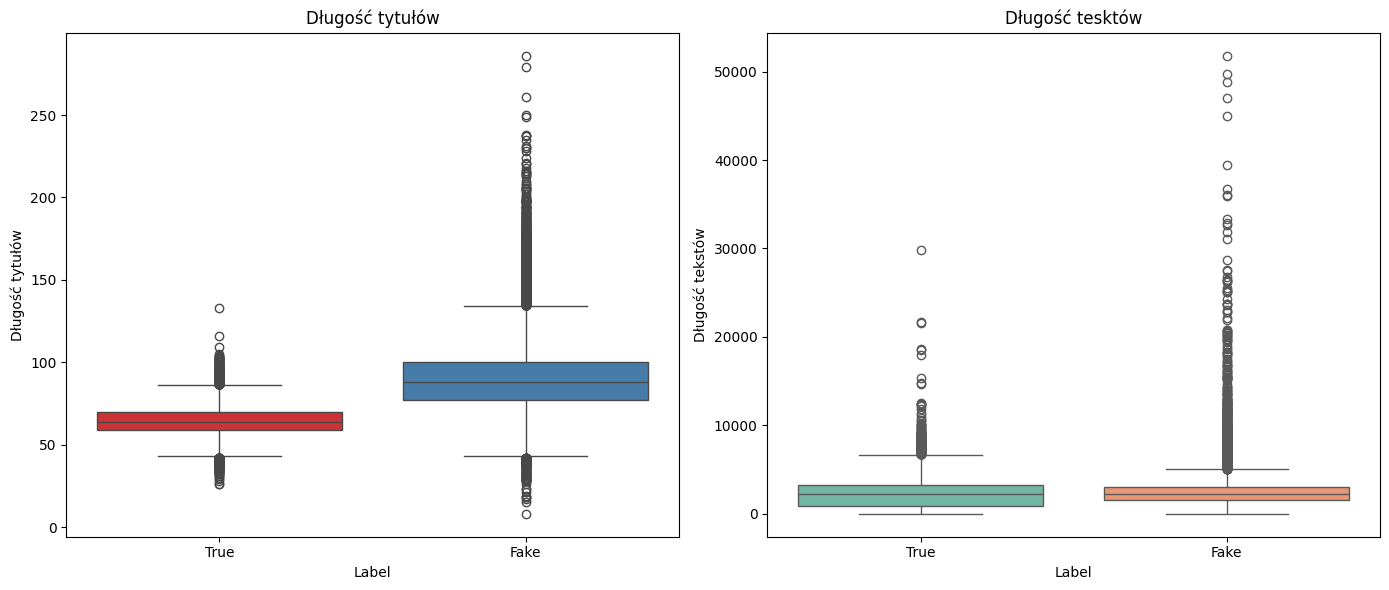

In [10]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(df, x='label', y='title_length', palette='Set1')
plt.title('Długość tytułów')
plt.xticks([0, 1], ['True', 'Fake'])
plt.xlabel('Label')
plt.ylabel('Długość tytułów')

plt.subplot(1,2,2)
sns.boxplot(df, x='label',y='text_length', palette='Set2')
plt.title('Długość tesktów')
plt.xticks([0, 1], ['True', 'Fake'])
plt.xlabel('Label')
plt.ylabel('Długość tekstów')

plt.tight_layout()
plt.show()

1. **Długość tytułów**: Tytuły fake newsów są średnio dłuższe **(91.3)** niż tytuły prawdziwych artykułów **(64.6)**.
2. **Długość tekstów**: Różnica w średniej długości tekstów między fake newsami **(2486.46)** a prawdziwymi artykułami **(2378.7)** jest niewielka.

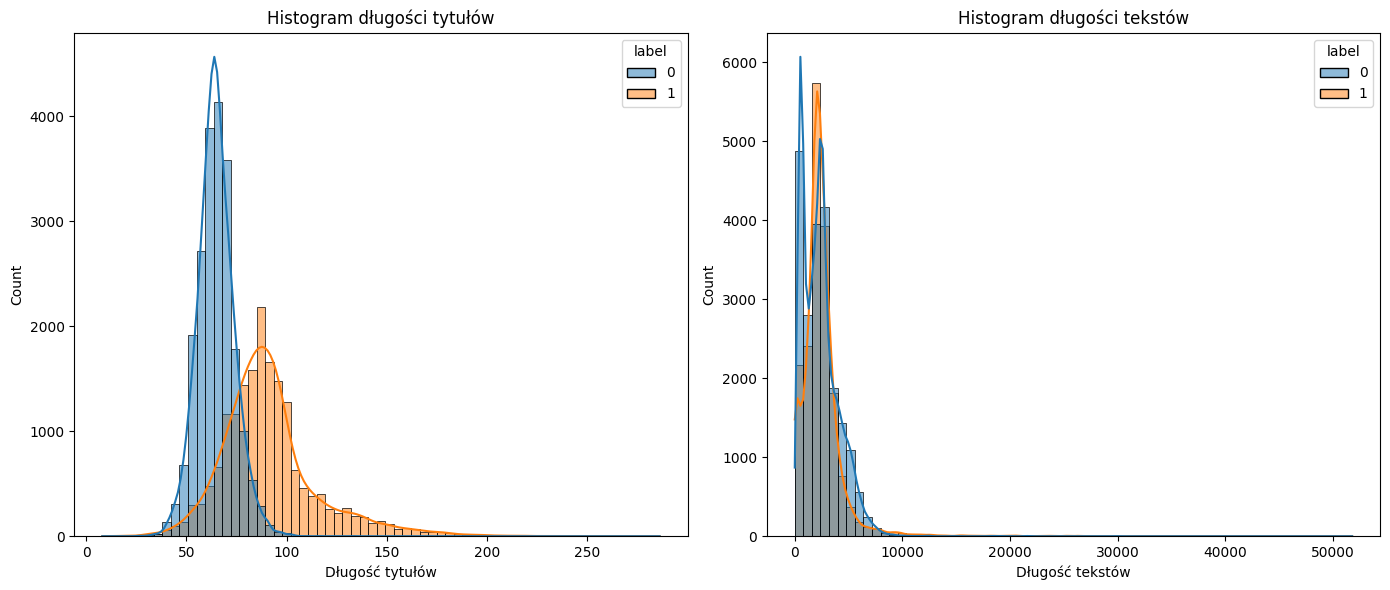

In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
sns.histplot(df,x='title_length',hue='label',kde=True, bins=65)
plt.title('Histogram długości tytułów')
plt.xlabel('Długość tytułów')

plt.subplot(1,2,2)
sns.histplot(df,x='text_length',hue='label',kde=True, color='green', bins=65)
plt.title('Histogram długości tekstów')
plt.xlabel('Długość tekstów')

plt.tight_layout()
plt.show()

title           49
text            49
date            49
label           49
title_length    49
text_length     49
dtype: int64


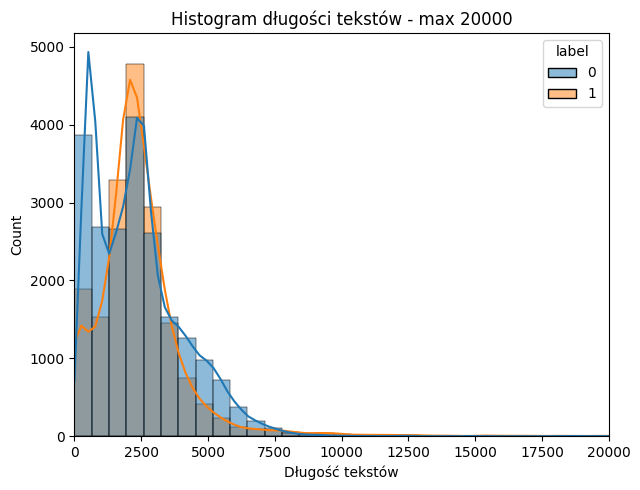

In [12]:
print(df[df['text_length']>20000].count())

plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
sns.histplot(df,x='text_length',hue='label',kde=True, color='green', bins=80)
plt.title('Histogram długości tekstów - max 20000')
plt.xlim((0,20000))
plt.xlabel('Długość tekstów')
plt.tight_layout()
plt.show()

Histogramy potwierdzają, że tytuły fake newsów są średnio dłuższe niż tytuły prawdziwych artykułów, co sugeruje, że **title_length** może być cennym featurem. Długość tekstów nie wykazuje, aż takiego wpływu na klasyfikację.


In [13]:
print("Najkrótszy tytuł:")
print(df.loc[df['title_length'].idxmin(), ['title', 'label']])

print("\nNajdłuższy tytuł:")
print(df.loc[df['title_length'].idxmax(),['title','label']])

Najkrótszy tytuł:
title    Homepage
label           1
Name: 22343, dtype: object

Najdłuższy tytuł:
title    THIS IS GREAT! ANTI-HILLARY STREET ART POPS UP...
label                                                    1
Name: 30391, dtype: object


In [14]:
print("\nNajkrótszy teskt:")
print(df.loc[df['text_length'].idxmin(), ['text','label','text_length']])

print("\nNajdłuższy tekst:")
print(df.loc[df['text_length'].idxmax(),['text','label','text_length']])


Najkrótszy teskt:
text            
label          1
text_length    1
Name: 286, dtype: object

Najdłuższy tekst:
text            Funny how secrets travel. I d start to believ...
label                                                          1
text_length                                                51794
Name: 36037, dtype: object


# Analiza słów kluczowych

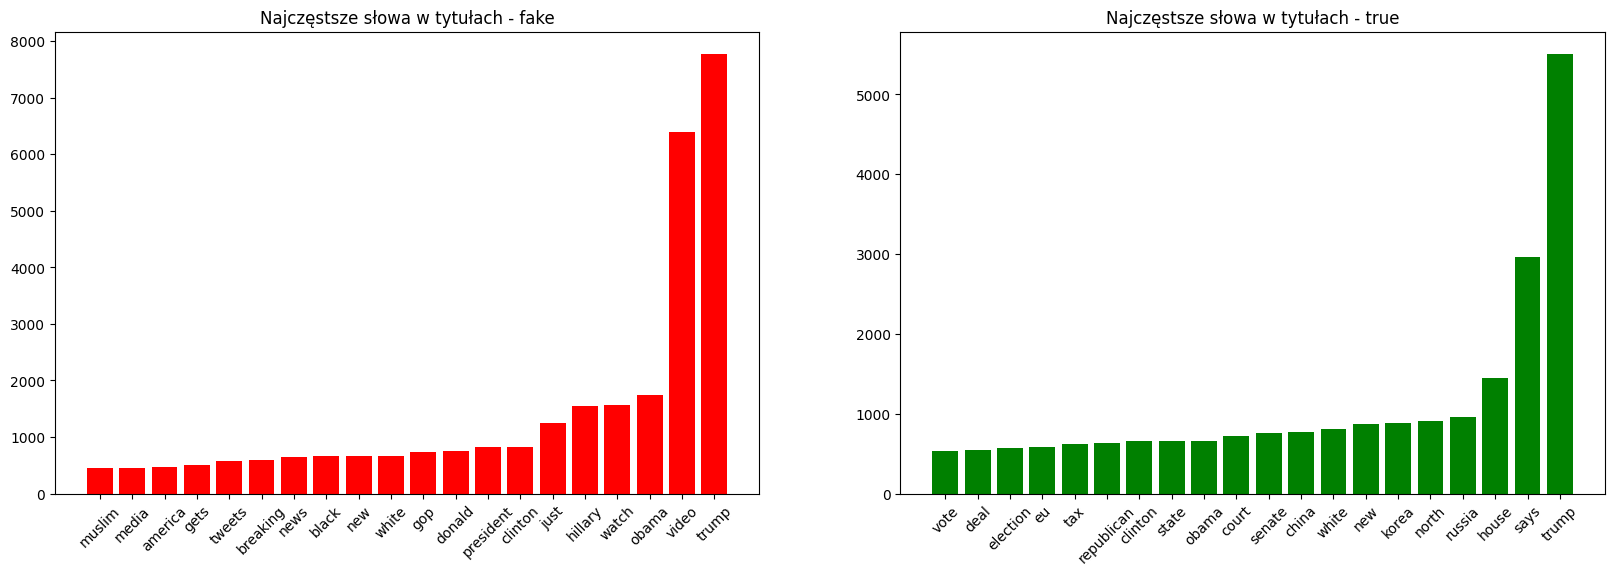

In [15]:
fake_titles = df[df['label']==1]['title']
fake_title_vectorizer = CountVectorizer(stop_words='english',max_features=20)
X_fake_title = fake_title_vectorizer.fit_transform(fake_titles)
fake_title_freq = dict(
    sorted(
        zip(fake_title_vectorizer.get_feature_names_out(), X_fake_title.sum(axis=0).A1),key = lambda x: x[1])
    )

true_titles = df[df['label']==0]['title']
true_title_vectorizer = CountVectorizer(stop_words='english',max_features=20)
X_true_title = true_title_vectorizer.fit_transform(true_titles)
true_title_freq = dict(
    sorted(
        zip(true_title_vectorizer.get_feature_names_out(), X_true_title.sum(axis=0).A1),key = lambda x: x[1]
        )
    )

plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.bar(fake_title_freq.keys(), fake_title_freq.values(), color='red')
plt.title('Najczęstsze słowa w tytułach - fake')
plt.tick_params(axis='x', rotation=45)

plt.subplot(1,2,2)
plt.bar(true_title_freq.keys(), true_title_freq.values(), color='green')
plt.title('Najczęstsze słowa w tytułach - true')
plt.tick_params(axis='x', rotation=45)

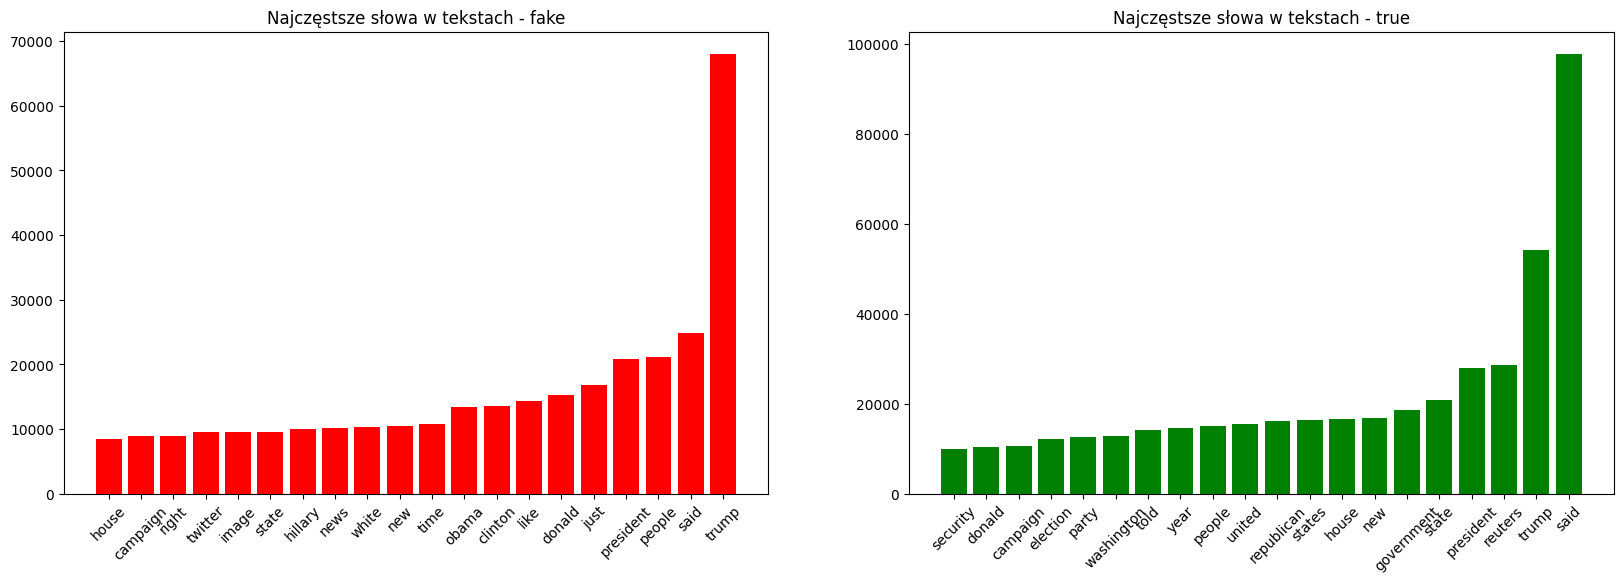

In [16]:
fake_text = df[df['label']==1]['text']
fake_text_vectorizer = CountVectorizer(stop_words='english',max_features=20)
X_fake_text = fake_text_vectorizer.fit_transform(fake_text)
fake_text_freq = dict(
    sorted(
        zip(fake_text_vectorizer.get_feature_names_out(), X_fake_text.sum(axis=0).A1),key = lambda x: x[1])
    )
true_text = df[df['label']==0]['text']
true_text_vectorizer = CountVectorizer(stop_words='english',max_features=20)
X_true_text = true_text_vectorizer.fit_transform(true_text)
true_text_freq = dict(
    sorted(
        zip(true_text_vectorizer.get_feature_names_out(), X_true_text.sum(axis=0).A1),key = lambda x: x[1]
        )
    )
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.bar(fake_text_freq.keys(), fake_text_freq.values(), color='red')
plt.title('Najczęstsze słowa w tekstach - fake')
plt.tick_params(axis='x', rotation=45)

plt.subplot(1,2,2)
plt.bar(true_text_freq.keys(), true_text_freq.values(), color='green')
plt.title('Najczęstsze słowa w tekstach - true')
plt.tick_params(axis='x', rotation=45)

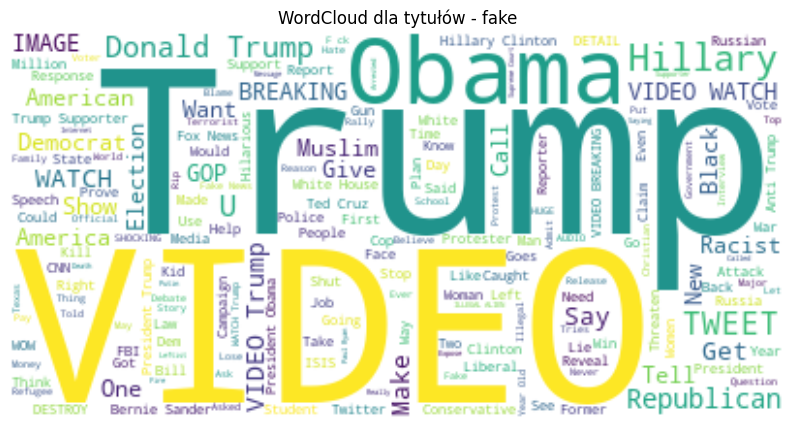

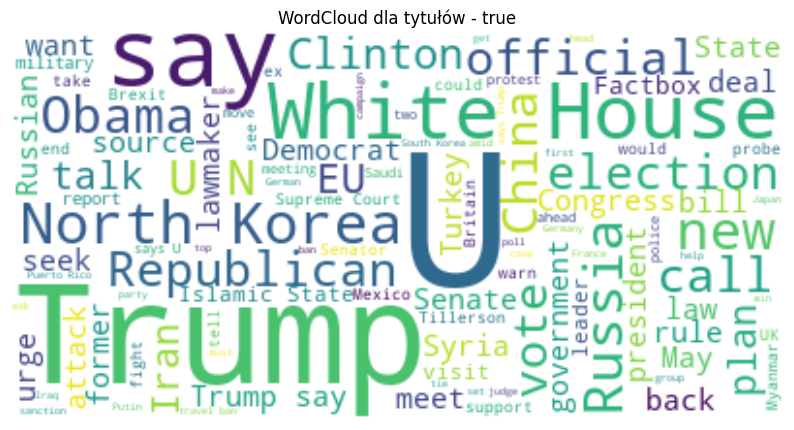

In [17]:
fake_title_text = fake_titles.str.cat(sep=' ')
wordcloud_fake_title = WordCloud(stopwords=stopwords.words('english'), background_color='white').generate(fake_title_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake_title, interpolation='bilinear')
plt.title('WordCloud dla tytułów - fake')
plt.axis('off')
plt.show()

true_title_text = true_titles.str.cat(sep=' ')
wordcloud_true_title = WordCloud(stopwords=stopwords.words('english'), background_color='white').generate(true_title_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_true_title, interpolation='bilinear')
plt.title('WordCloud dla tytułów - true')
plt.axis('off')
plt.show()

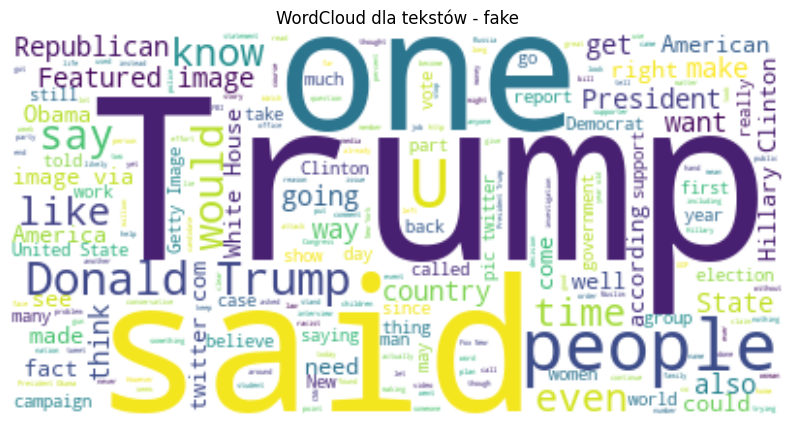

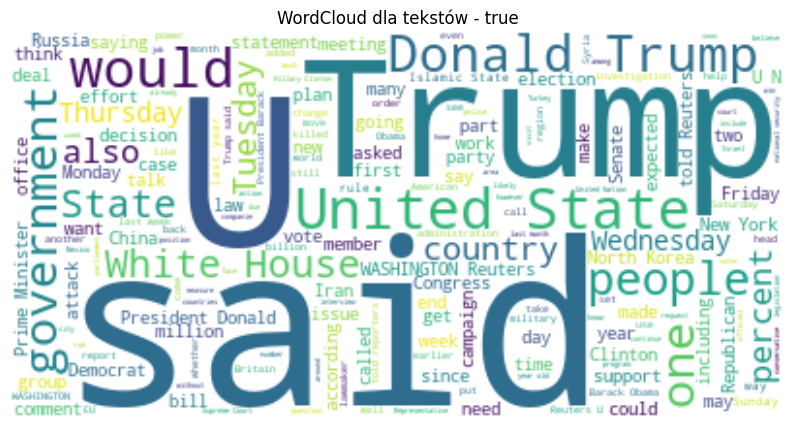

In [18]:
fake_text_text = fake_text.str.cat(sep=' ')
wordcloud_fake_text = WordCloud(stopwords=stopwords.words('english'),background_color='white').generate(fake_text_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fake_text, interpolation='bilinear')
plt.title('WordCloud dla tekstów - fake')
plt.axis('off')
plt.show()

true_text_text = true_text.str.cat(sep=' ')
wordcloud_true_text = WordCloud(stopwords=stopwords.words('english'),background_color='white').generate(true_text_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_true_text, interpolation='bilinear')
plt.title('WordCloud dla tekstów - true')
plt.axis('off')
plt.show()

Tytuły fake newsów i prawdziwych artykułów zawierają podobne słowa, ale w fake newsach często pojawiają się emocjonalne terminy, jak **"VIDEO", "BREAKING", "RACIST"** (widać w wordcloud dla fake news). W artykułach prawdziwych często występuje słowo **"Reuters"**, co wskazuje na wiarygodne źródło informacji.


# Analiza Czasowa

In [19]:
df['date'] = pd.to_datetime(df['date'],errors="coerce")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

df.head()

,title,text,date,label,title_length,text_length,year,month,day,weekday
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,2016-01-17,0,63,6517,2016.0,1.0,17.0,6.0
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,2017-11-19,0,87,2435,2017.0,11.0,19.0,6.0
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,2017-09-04,0,64,3431,2017.0,9.0,4.0,0.0
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,2016-01-11,1,90,2419,2016.0,1.0,11.0,0.0
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,2016-03-31,1,91,95,2016.0,3.0,31.0,3.0


In [22]:
df[['weekday','label']].groupby(by='weekday').mean()

,label
weekday,
0.0,0.452240
1.0,0.415020
2.0,0.399824
3.0,0.402009
4.0,0.418885
5.0,0.656557
6.0,0.625725


Najwyższy procent fake newsów występuje w **sobotę (5)** i **niedzielę (6)**, co sugeruje, że weekendy sprzyjają ich większemu rozpowszechnianiu. 

In [23]:
df[['day','label']].groupby(by='day').mean()

,label
day,
1.0,0.469068
2.0,0.484622
3.0,0.492411
4.0,0.480972
5.0,0.471774
6.0,0.437151
7.0,0.435789
8.0,0.460799
9.0,0.449128


Dzień miesiąca **nie ma wpływu** na rozprzestrzenianie fake newsów

# Analiza poziomu składni 

In [ ]:
def count_exclamation(x):
    title_ex = x['title'].count('!')
    text_ex = x['text'].count('!')
    return title_ex + text_ex

df['exclamation_count'] = df.apply(count_exclamation, axis=1)
print(df[['exclamation_count','label']].groupby(by='exclamation_count').mean())
print(df[['exclamation_count','label']].groupby(by='label').mean())

                      label
exclamation_count          
0                  0.354192
1                  0.854093
2                  0.920475
3                  0.952670
4                  0.938272
5                  0.940171
6                  0.902597
7                  0.968421
8                  0.945946
9                  0.953488
10                 1.000000
11                 0.888889
12                 0.818182
13                 1.000000
14                 1.000000
15                 1.000000
16                 1.000000
18                 1.000000
19                 1.000000
21                 1.000000
22                 1.000000
23                 1.000000
24                 1.000000
25                 1.000000
26                 1.000000
28                 1.000000
29                 1.000000
33                 1.000000
35                 1.000000
67                 1.000000
133                1.000000
       exclamation_count
label                   
0               0.063028
1

Z danych wynika, że liczba wykrzykników jest bardzo znaczącym wskaźnikiem w wykrywaniu fake newsów.

In [27]:
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 5.6 MB/s eta 0:00:03
     --------- ------------------------------ 2.9/12.8 MB 9.9 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 9.7 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 10.1 MB/s eta 0:00:01
     ------------------------------ -------- 10.0/12.8 MB 10.9 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 10.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 10.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [28]:
def avg_sentence_length(text, counter):
    doc = nlp(text)
    lengths = [len([token for token in sent if not token.is_punct]) for sent in doc.sents]
    
    if counter % 1000 == 0:
        print(f"Przetworzono {counter} wierszy...")
    
    return sum(lengths)/ len(lengths) if lengths else 0

def process_with_progress(df_column):
    results = []
    for idx, text in enumerate(df_column):
        result = avg_sentence_length(text, idx)
        results.append(result)
    return results

df['avg_text_sent_length'] = process_with_progress(df['text'])
df['avg_title_sent_length'] = process_with_progress(df['title'])

df.head()

Przetworzono 0 wierszy...
Przetworzono 1000 wierszy...
Przetworzono 2000 wierszy...
Przetworzono 3000 wierszy...
Przetworzono 4000 wierszy...
Przetworzono 5000 wierszy...
Przetworzono 6000 wierszy...
Przetworzono 7000 wierszy...
Przetworzono 8000 wierszy...
Przetworzono 9000 wierszy...
Przetworzono 10000 wierszy...
Przetworzono 11000 wierszy...
Przetworzono 12000 wierszy...
Przetworzono 13000 wierszy...
Przetworzono 14000 wierszy...
Przetworzono 15000 wierszy...
Przetworzono 16000 wierszy...
Przetworzono 17000 wierszy...
Przetworzono 18000 wierszy...
Przetworzono 19000 wierszy...
Przetworzono 20000 wierszy...
Przetworzono 21000 wierszy...
Przetworzono 22000 wierszy...
Przetworzono 23000 wierszy...
Przetworzono 24000 wierszy...
Przetworzono 25000 wierszy...
Przetworzono 26000 wierszy...
Przetworzono 27000 wierszy...
Przetworzono 28000 wierszy...
Przetworzono 29000 wierszy...
Przetworzono 30000 wierszy...
Przetworzono 31000 wierszy...
Przetworzono 32000 wierszy...
Przetworzono 33000 wier

,title,text,date,label,title_length,text_length,year,month,day,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,2016-01-17,0,63,6517,2016.0,1.0,17.0,6.0,0,22.620000,11.0
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,2017-11-19,0,87,2435,2017.0,11.0,19.0,6.0,0,25.062500,11.0
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,2017-09-04,0,64,3431,2017.0,9.0,4.0,0.0,0,26.608696,10.0
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,2016-01-11,1,90,2419,2016.0,1.0,11.0,0.0,0,17.520000,18.0
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,2016-03-31,1,91,95,2016.0,3.0,31.0,3.0,0,16.000000,7.0


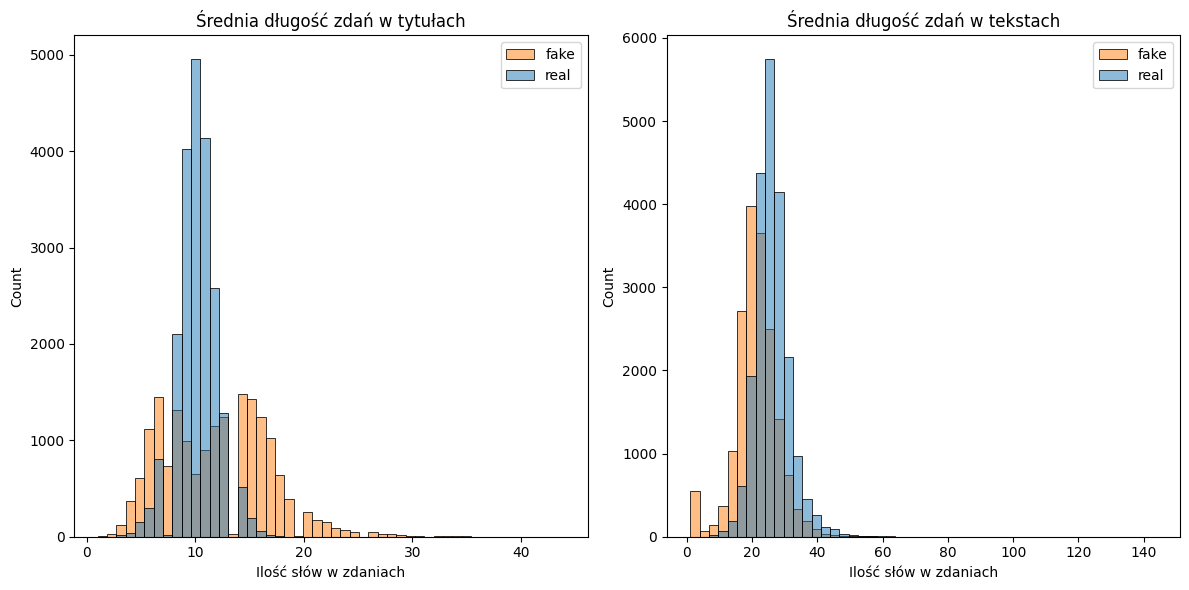

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.histplot(df,x='avg_title_sent_length', hue = 'label',bins=50)
plt.title('Średnia długość zdań w tytułach')
plt.legend(['fake','real'])
plt.xlabel('Ilość słów w zdaniach')

plt.subplot(1,2,2)
sns.histplot(df,x='avg_text_sent_length', hue = 'label',bins=50)
plt.title('Średnia długość zdań w tekstach')
plt.legend(['fake','real'])
plt.xlabel('Ilość słów w zdaniach')

plt.tight_layout()
plt.show()

**Tytuły**: W tytułach fake newsów zdania są zazwyczaj albo krótkie, albo długie, podczas gdy w artykułach prawdziwych dominują średniej długości zdania.

**Teksty**: W tekstach fake newsów dominują raczej krótsze zdania.

Długość zdań w tytułach i tekstach może stanowić cenny wskaźnik.

In [30]:
titles = df['title'].tolist()
titles_docs = list(nlp.pipe(titles))
df['title_verb_count'] = [sum(1 for token in doc if token.pos_ == 'VERB') for doc in titles_docs]
print('Gotowe - 1')
df['title_adj_count'] = [sum(1 for token in doc if token.pos_ == 'ADJ') for doc in titles_docs]
print('Gotowe - 2')

Gotowe - 1
Gotowe - 2


In [31]:
df.head(10)

,title,text,date,label,title_length,text_length,year,month,day,weekday,exclamation_count,avg_text_sent_length,avg_title_sent_length,title_verb_count,title_adj_count
0,Many 'lost' voters say they have found their c...,WASHINGTON/NEW YORK (Reuters) - Ted Wade hasn’...,2016-01-17,0,63,6517,2016.0,1.0,17.0,6.0,0,22.620000,11.000000,3,1
1,"Iranian Revolutionary Guards commander, anothe...",BEIRUT (Reuters) - A commander in Iran s elite...,2017-11-19,0,87,2435,2017.0,11.0,19.0,6.0,0,25.062500,11.000000,1,1
2,Cambodian leader gets China's backing as West ...,PHNOM PENH (Reuters) - Cambodian Prime Ministe...,2017-09-04,0,64,3431,2017.0,9.0,4.0,0.0,0,26.608696,10.000000,2,1
3,Ex-KKK Grand Wizard: Maine Gov. Right To Call...,David Duke is perhaps one of the most notoriou...,2016-01-11,1,90,2419,2016.0,1.0,11.0,0.0,0,17.520000,18.000000,1,0
4,FINGER-WAGGING GRANNY HILLARY CLINTON Blows Up...,Hillary Clinton shows her true colors here wit...,2016-03-31,1,91,95,2016.0,3.0,31.0,3.0,0,16.000000,7.000000,1,0
5,Joe Scarborough Defends President Obama’s Emo...,"While it s often difficult to notice, Joe Scar...",2016-01-06,1,88,4232,2016.0,1.0,6.0,2.0,0,16.522727,13.000000,0,1
6,What Dan Rather Has To Say About Trump’s ‘Dea...,"On Tuesday afternoon, legendary journalist Dan...",2017-02-14,1,86,2387,2017.0,2.0,14.0,1.0,0,16.692308,16.000000,2,2
7,"Republican: Porn Is Worse Than Cocaine, Gov’t...",A Republican state senator in Utah believes th...,2016-01-31,1,83,1921,2016.0,1.0,31.0,6.0,0,18.882353,15.000000,2,1
8,"Trump, under fire on many fronts, expands camp...","WASHINGTON (Reuters) - Donald Trump, under pre...",2016-04-07,0,55,2457,2016.0,4.0,7.0,3.0,0,25.937500,9.000000,1,2
9,FLASHBACK: NANCY PELOSI Makes Outrageous Claim...,"What a disgusting, out of touch racist she is....",2016-07-28,1,91,147,2016.0,7.0,28.0,3.0,0,12.000000,4.666667,1,1


In [32]:
print(df[['title_verb_count','label']].groupby('label').mean())
print(df[['title_verb_count','label']].groupby('title_verb_count').mean())


       title_verb_count
label                  
0              1.502665
1              1.628434
                     label
title_verb_count          
0                 0.610056
1                 0.394681
2                 0.408911
3                 0.548862
4                 0.785013
5                 0.908257
6                 1.000000
7                 1.000000
8                 1.000000
10                1.000000


In [33]:
print(df[['title_adj_count','label']].groupby('label').mean())
print(df[['title_adj_count','label']].groupby('title_adj_count').mean())


       title_adj_count
label                 
0             0.883616
1             0.543333
                    label
title_adj_count          
0                0.558424
1                0.386213
2                0.313721
3                0.279321
4                0.285714
5                0.313433
6                0.333333
7                0.250000


Analiza liczby czasowników i przymiotników w tytułach wskazuje, że te cechy nie mają wyraźnego wpływu na klasyfikację fake newsów. Średnia liczba czasowników (**title_verb_count**) oraz przymiotników (**title_adj_count**) w tytułach jest dość zbliżona dla obu kategorii.

In [ ]:
df.to_csv('../data//old_data/processed/new_features_news_1.csv', index=False)
print("Udało się zapisać dane")

Udało się zapisać dane
